In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split 

In [5]:
# Load the data
df_all = pd.read_csv('data/220306_slugs_dataset.csv')
#df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

In [12]:
# Create some new features
df_inp['densDiff'] = df_inp['slugDen'] - df_inp['pockDen']      # Density difference
df_inp['centrFor'] = df_inp['slugVel']**2 * df_inp['densDiff']  # Proxy for centrifugal force

## Data Scaling & Splitting

In [6]:
df_scl = df_inp.copy(deep=True)

# Scale the data (min = 0, max = 1 for all columns)
scaler = preprocessing.MinMaxScaler()

# Scale using standard deviation
#scaler = preprocessing.StandardScaler() 

# Scale the data (min = 0, max = 1 for all columns)
scaler = preprocessing.MinMaxScaler((0, 1))

# Scale the data (min = -1, max = 1 for all columns)
#scaler = preprocessing.MinMaxScaler((-1, 1))

df_scl = pd.DataFrame(scaler.fit_transform(df_scl), columns = df_scl.columns, index = df_scl.index)

# Create percentile field for sratification
df_scl['splits'] = pd.qcut(df_scl['out_oopDisp_mm_n2'], 100, labels=False)

# Create train and test splits (10% test)
# Test will be held back for final model(s) evaluation and comparison
train, test = train_test_split(df_scl, test_size=0.10, stratify=df_scl['splits'], random_state=0) 

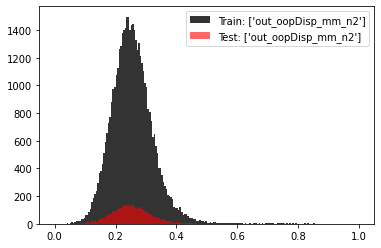


Max (train) =  1.0
Max (test) =  0.9


In [7]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(test[param].values, bins=n_bins, label = f'Test: {param}', color = 'red', alpha=0.6, zorder=2)
axs.legend(loc = 'upper right')
plt.show()
print('\nMax (train) = ', round(train[param].values.max(), 1))
print('Max (test) = ', round(test[param].values.max(), 1))

In [8]:
# Create validation subset dataset of training (10% validation)
# Validation will be used for initial hyperparameter and architecture tuning
# Cross validation may also be used to give a more robust estimate of performance before final testing
train, val = train_test_split(train, test_size=0.1, stratify=train['splits'], random_state=0) 

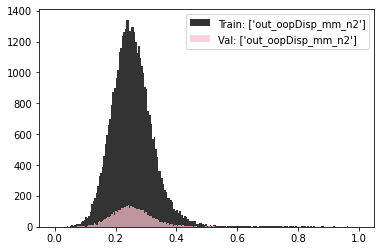


Max (test) =  0.9
Max (val) =  0.9


In [9]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(val[param].values, bins=n_bins, label = f'Val: {param}', color = 'pink', alpha=0.7, zorder=3)
axs.legend(loc = 'upper right')
plt.show()
print('\nMax (test) = ', round(test[param].values.max(), 1))
print('Max (val) = ', round(val[param].values.max(), 1))

In [10]:
# Drop the splits column
train = train.drop(['splits'], axis=1)
val = val.drop(['splits'], axis=1)
test = test.drop(['splits'], axis=1)

In [11]:
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']
pred_features = [
    'slugDen',  # 0
    'slugLen',  # 1
    'pockDen',  # 2
    'pockLen',  # 3
    'slugVel',  # 4
    'basePer',  # 5
    'baseAmp',  # 6
    'basePha',  # 7
    'simTime',  # 8
    'densDiff', # 9
    'centrFor'  # 10
]
pred_features = pred_features[:]

X_train = train.filter(pred_features)
y_train = train.filter(pred_target)

X_val = val.filter(pred_features)
y_val = val.filter(pred_target)

X_test = test.filter(pred_features)
y_test = test.filter(pred_target)

In [22]:
# Write data to csv
# Note: train and val can be combined later for cv and final model training.
# Test is for final evaluation of model(s) following completion of hyperparameter tuning
fo = 'data/'
X_train.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_X_train.csv', index=True)
y_train.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_y_train.csv', index=True)

X_val.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_X_val.csv', index=True)
y_val.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_y_val.csv', index=True)

X_test.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_X_test.csv', index=True)
y_test.to_csv(f'{fo}{date.today().strftime("%y%m%d")}_y_test.csv', index=True)

In [23]:
print('No. of train rows:', len(X_train))
print('No. of validation rows:', len(X_val)) 
print('No. of test rows:', len(X_test))

No. of train rows: 40479
No. of validation rows: 4498
No. of test rows: 4998
